In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import (accuracy_score,
                            classification_report,
                            recall_score, precision_score, f1_score,
                            confusion_matrix,
                             roc_auc_score)

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

#!pip install --quiet shap==0.39.0
#import shap

%matplotlib inline

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/vehicle_data_train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


##About Data
* id-->	Unique ID for the customer
* Gender-->	Gender of the customer
* Age-->	Age of the customer
* Driving_License-->0: Customer does not have DL, 1 : Customer already has DL
* Region_Code-->	Unique code for the region of the customer
*Previously_Insured--> 1:Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance
* Vehicle_Age	Age of the Vehicle
* Vehicle_Damage--> 1: Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.
* Annual_Premium-->	The amount customer needs to pay as premium in the year
* Policy_Sales_Channel-->	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.
* Vintage-->	Number of Days, Customer has been associated with the company
* Response-->	1 : Customer is interested, 0 : Customer is not interested

#Hypothesis:
* what make a customer interested in vehicle insurance?
  * I would definetly buy insurance if i have brand new vehicle or recent brought one.
  * WOuld look into the cost of buying an insurance
  * I have a driving license.
* If i am selling insurance to customers , who would i target and why?
  * People with vehicle age which is old, due to higher chances of malfunctions
  * Would look into people who dont have insurance yet? bcaz one's who alrady have maybe be satisfied with their plan
  * Would look into what are the effective ways to reach out to customers


#Basic EDA

In [ ]:
df.shape

(381109, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [ ]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
df['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

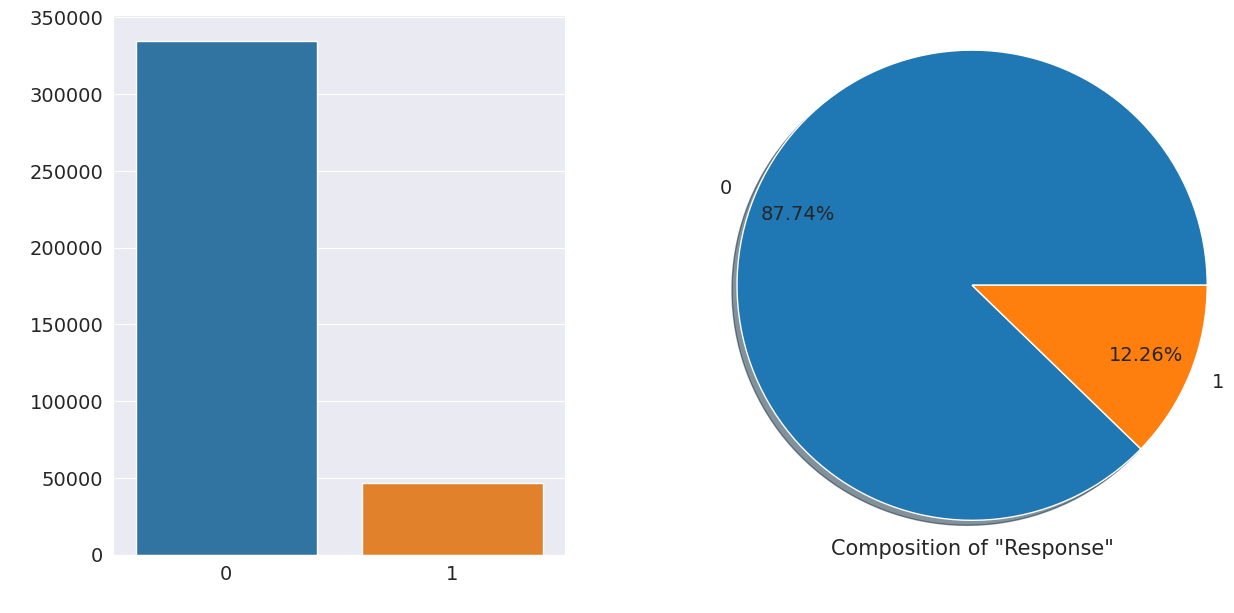

In [ ]:
# checking the target
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=df["Response"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)

ax2 = plt.subplot(1, 2, 2)
response_counts = df["Response"].value_counts()
plt.pie(response_counts,
        labels=response_counts.index,  # Ensure labels match the counts
        autopct='%1.2f%%',
        pctdistance=0.8,
        shadow=True,
        radius=1.3,
        textprops={'fontsize': 14}
       )
plt.xlabel('Composition of "Response"', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)

plt.show()

In [ ]:
#Target Values distribution is 87.74% and 12.26%
#ie 87% of customers are not intrested in buying insurance
# This data is heavily skewed

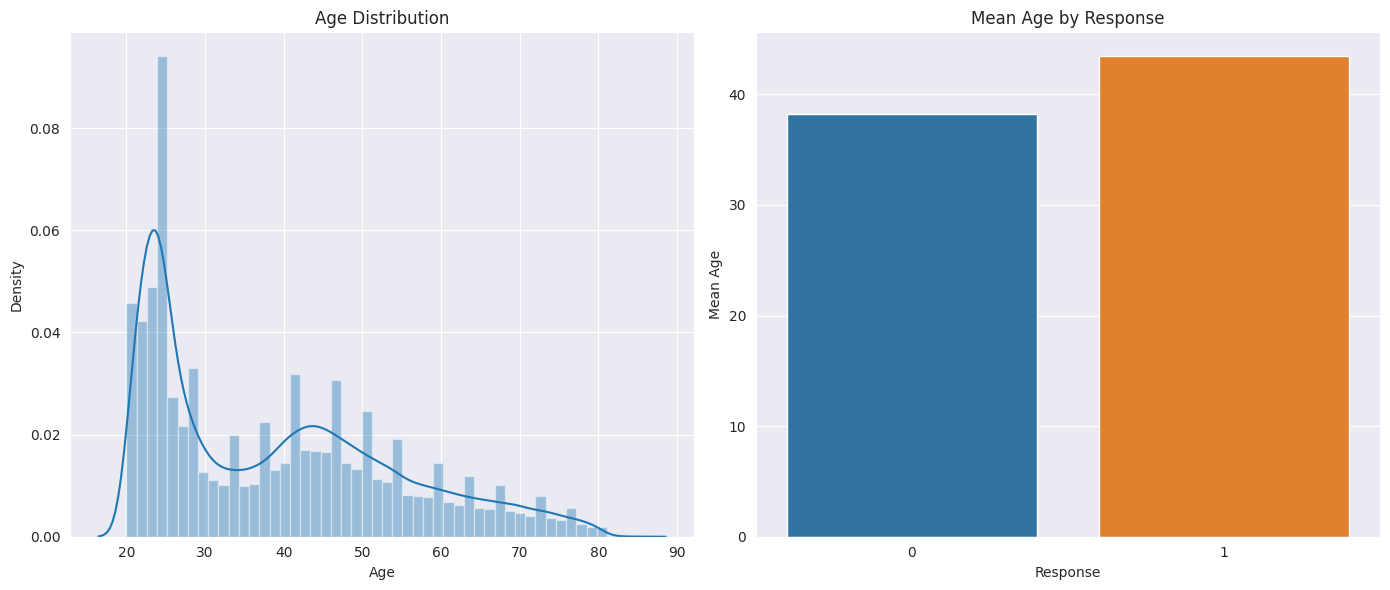

In [ ]:
plt.figure(figsize=(14, 6))

# Create the first subplot for the distribution plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.distplot(df['Age'])
plt.title('Age Distribution')  # Optional title for the first plot

# Create the second subplot for the box plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.barplot(x='Response', y='Age', data=df, estimator=np.mean, ci=None)
plt.title('Mean Age by Response')
plt.xlabel('Response')
plt.ylabel('Mean Age')

# Adjust the spacing between the plots
plt.tight_layout()

# Display the plots
plt.show()

#AGE

* The data indicates a higher concentration of individuals aged between 20 to 26 years.
* Additionally, the average age of those showing interest in insurance is 43 years, while for those not interested, it is 38 years.

#Gender

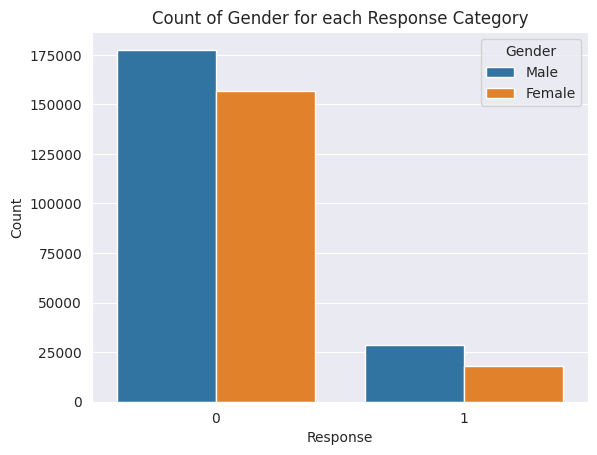

In [ ]:
sns.countplot(x='Response', hue='Gender', data=df)

plt.title('Count of Gender for each Response Category')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

# in both cases men proportion are higher, which doenst give us any info

#Driving_License

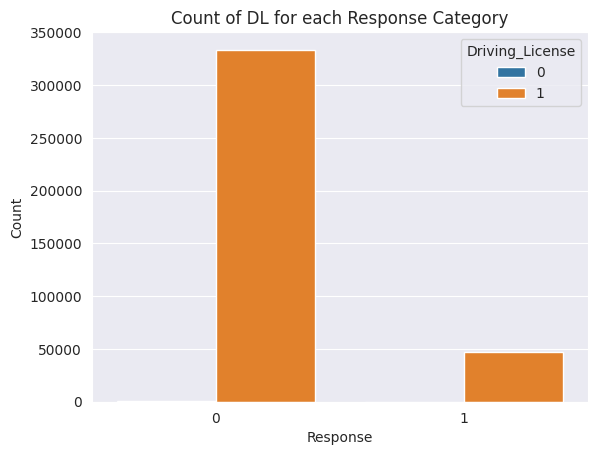

In [ ]:
sns.countplot(x='Response', hue='Driving_License', data=df)

plt.title('Count of DL for each Response Category')
plt.xlabel('Response')
plt.ylabel('Count')
plt.show()

# in both cases men proportion are higher, which doenst give us any info

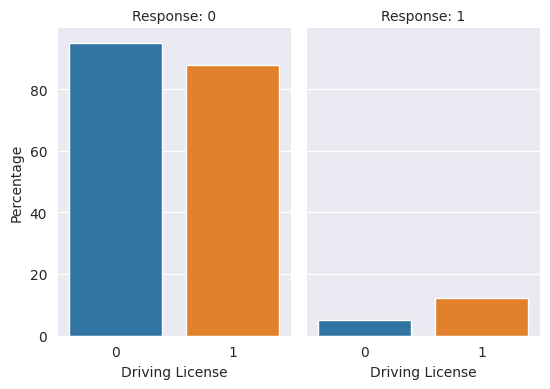

In [ ]:
#Majority of them are not intreted in buying Inusrance,
#People About

   Driving_License  Response   count  percentage
0                0         0     771   94.950739
1                0         1      41    5.049261
2                1         0  333628   87.728276
3                1         1   46669   12.271724


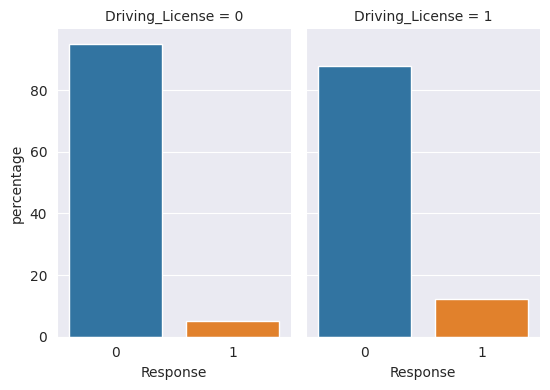

In [ ]:
dl_resp = df.groupby(['Driving_License', 'Response']).size().to_frame().rename(columns={0:'count'}).reset_index()
total_counts = dl_resp.groupby('Driving_License')['count'].sum()

# Calculating the percentage for each row
dl_resp['percentage'] = dl_resp.apply(lambda row: (row['count'] / total_counts[row['Driving_License']]) * 100, axis=1)

print(dl_resp)
g = sns.catplot(x="Response", y="percentage",col="Driving_License",
                data=dl_resp, kind="bar",
                height=4, aspect=.7);


* The bar plot shows that 95% of people without a driving license are not interested in insurance, while only 5% are intrested.
* Among those with a driving license, 88% are not interested in insurance, but 12% are. This suggests a stronger interest in insurance among
license holders.

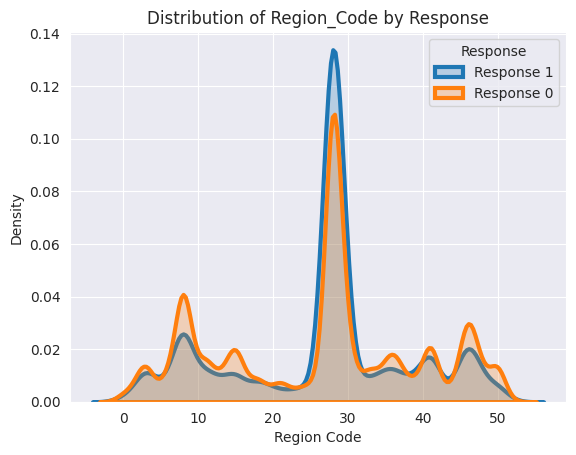

In [ ]:
response_categories = df['Response'].unique()

# Loop through the unique 'Response' values to create a distplot for each
for response in response_categories:
    subset = df[df['Response'] == response]
    sns.distplot(subset['Region_Code'], hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 3},
                 label=f'Response {response}')

# Place the legend
plt.legend(title='Response')

# Set the titles and labels
plt.title('Distribution of Region_Code by Response')
plt.xlabel('Region Code')
plt.ylabel('Density')

# Show the plot
plt.show()



#PreviousInsurance

   Previously_Insured  Response   count  percentage
0                   0         0  159929   77.454584
1                   0         1   46552   22.545416
2                   1         0  174470   99.909522
3                   1         1     158    0.090478


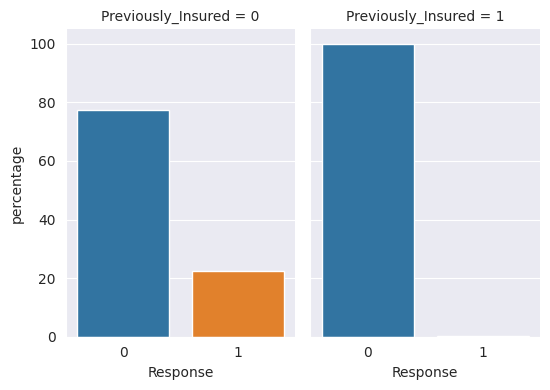

In [ ]:
pi_resp = df.groupby(['Previously_Insured', 'Response']).size().to_frame().rename(columns={0:'count'}).reset_index()
total_counts = pi_resp.groupby('Previously_Insured')['count'].sum()

# Calculating the percentage for each row
pi_resp['percentage'] = pi_resp.apply(lambda row: (row['count'] / total_counts[row['Previously_Insured']]) * 100, axis=1)

print(pi_resp)
g = sns.catplot(x="Response", y="percentage",col="Previously_Insured",
                data=pi_resp, kind="bar",
                height=4, aspect=.7);


#As we can see that 22% of people are intrested in getting insurance where as thos who already had insurance were not at all intrested.


#Vehicle Age

  Vehicle_Age  Response   count  percentage
0    1-2 Year         0  165510   82.624453
1    1-2 Year         1   34806   17.375547
2    < 1 Year         0  157584   95.629483
3    < 1 Year         1    7202    4.370517
4   > 2 Years         0   11305   70.625351
5   > 2 Years         1    4702   29.374649


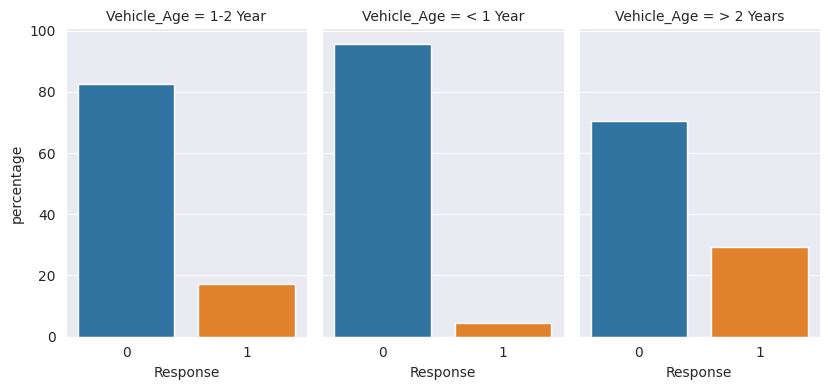

In [ ]:
va_resp = df.groupby(['Vehicle_Age', 'Response']).size().to_frame().rename(columns={0:'count'}).reset_index()
total_counts = va_resp.groupby('Vehicle_Age')['count'].sum()

# Calculating the percentage for each row
va_resp['percentage'] = va_resp.apply(lambda row: (row['count'] / total_counts[row['Vehicle_Age']]) * 100, axis=1)

print(va_resp)
g = sns.catplot(x="Response", y="percentage",col="Vehicle_Age",
                data=va_resp, kind="bar",
                height=4, aspect=.7);


#as suspected, Greter the vechicel age , more chances of buying insurance, since new vehicle has free services for some time.
#25% people with vechile age >2 years will be buying the insurance.


In [ ]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

  Vehicle_Age  Response   count  percentage
0    1-2 Year         0  165510   82.624453
1    1-2 Year         1   34806   17.375547
2    < 1 Year         0  157584   95.629483
3    < 1 Year         1    7202    4.370517
4   > 2 Years         0   11305   70.625351
5   > 2 Years         1    4702   29.374649


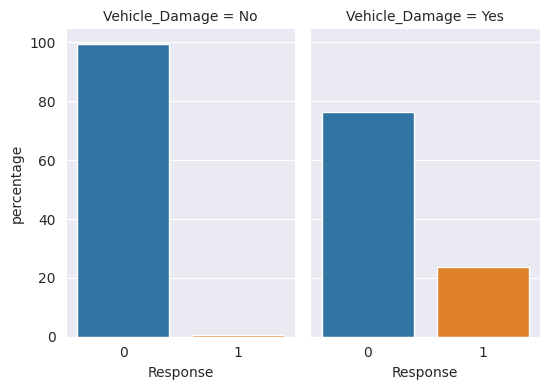

In [ ]:
vd_resp = df.groupby(['Vehicle_Damage', 'Response']).size().to_frame().rename(columns={0:'count'}).reset_index()
total_counts = vd_resp.groupby('Vehicle_Damage')['count'].sum()

# Calculating the percentage for each row
vd_resp['percentage'] = vd_resp.apply(lambda row: (row['count'] / total_counts[row['Vehicle_Damage']]) * 100, axis=1)

print(va_resp)
g = sns.catplot(x="Response", y="percentage",col="Vehicle_Damage",
                data=vd_resp, kind="bar",
                height=4, aspect=.7);


In [ ]:
#Again, 20%+ People with vechile damage are likley to buy insurance

#Premium

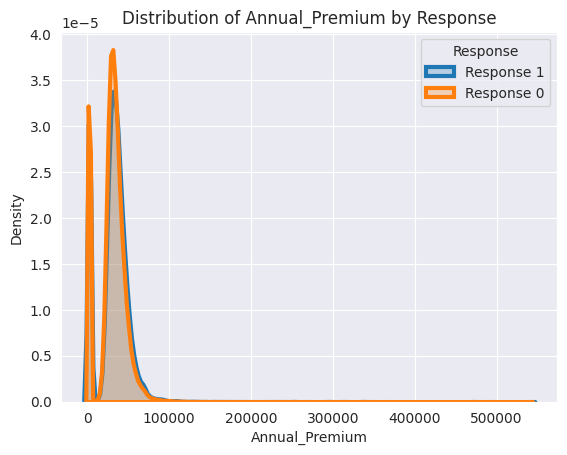

In [ ]:
#sns.distplot(df['Annual_Premium'])
response_categories = df['Response'].unique()

# Loop through the unique 'Response' values to create a distplot for each
for response in response_categories:
    subset = df[df['Response'] == response]
    sns.distplot(subset['Annual_Premium'], hist=False, kde=True,
                 kde_kws={'shade': True, 'linewidth': 3},
                 label=f'Response {response}')

# Place the legend
plt.legend(title='Response')

# Set the titles and labels
plt.title('Distribution of Annual_Premium by Response')
plt.xlabel('Annual_Premium')
plt.ylabel('Density')

# Show the plot
plt.show()



#Annual Premium is highly skewed towards rights with most people paying between 0 to 100000

In [ ]:
#we can see some outliers here
df['Annual_Premium'].describe()

# as we can see that we have min value 2630, 75% vlaues is 39000+ but max value is 540165 which is way off .

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

In [ ]:
#lets digg deeper

df[df['Annual_Premium']>39400]['Response'].value_counts()

0    81398
1    13879
Name: Response, dtype: int64

In [ ]:

df[df['Annual_Premium']>100000]['Response'].value_counts()

0    655
1    123
Name: Response, dtype: int64

#Policy_Sales_Channel

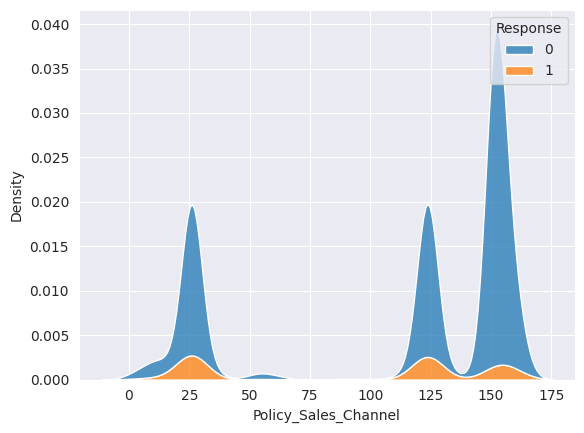

In [ ]:
sns.kdeplot(x='Policy_Sales_Channel',data=df,hue='Response', multiple='stack');

#Vintage

Text(0, 0.5, 'Mean Age')

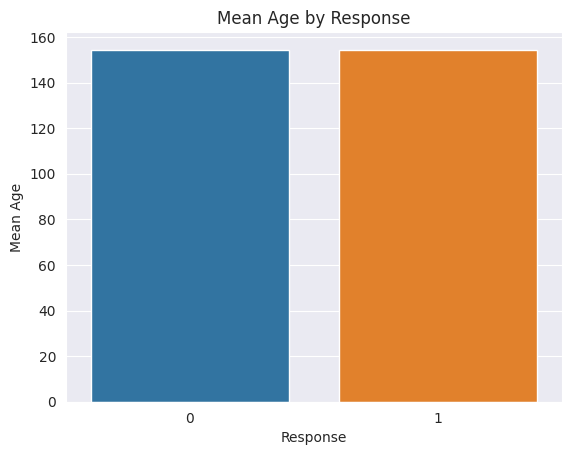

In [ ]:
sns.barplot(x='Response', y='Vintage', data=df, estimator=np.mean, ci=None)
plt.title('Mean Age by Response')
plt.xlabel('Response')
plt.ylabel('Mean Age')

#So its same

#Modelling.


In [ ]:

df1 = df.copy()

In [ ]:
from sklearn.linear_model import LogisticRegression
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'lr' in kwargs.keys() and kwargs['lr']:
        lr = LogisticRegression()
        lr.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = lr.predict(X_test._get_numeric_data())
        scores['lr']= [accuracy_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)
    if 'dt' in kwargs.keys() and kwargs['dt']:
        dt = DecisionTreeClassifier()
        dt.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = lr.predict(X_test._get_numeric_data())
        scores['dt']= [accuracy_score(y_test, y_pred)]

    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)



    return scores

In [ ]:

df1 = df.copy()
df1 = df1.drop('id',axis=1)


df1['Gender'] = df1['Gender'].map({'Male': 1, 'Female': 0})
df1['Vehicle_Age'] = df1['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
df1['Vehicle_Damage'] = df1['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

X = df1.drop('Response',axis=1)
y = df1['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = df1['Response'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(266776, 10) (114333, 10) (266776,) (114333,)


In [ ]:
X_train.head()

#droppin of ID column,
#Gender can be 1 and 0
#Driving Licine can be 1 and 0
#Vehilce age should be oridal
#Vehicel damage 1 and 0
#

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
223531,0,46,1,23.0,1,1,0,34564.0,26.0,71
337977,1,51,1,28.0,1,1,0,31982.0,26.0,76
320307,0,40,1,33.0,0,1,0,2630.0,12.0,276
261303,0,28,1,4.0,1,0,0,2630.0,152.0,223
71160,0,21,1,37.0,1,0,0,30939.0,160.0,38


In [ ]:
num_cols = ['Age','Region_Code','Annual_Premium','Policy_Sales_Channel','Vintage']
sc = StandardScaler()
X_train[num_cols] = sc.fit_transform(X_train[num_cols])
X_test[num_cols] = sc.transform(X_test[num_cols])

In [ ]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
55914,1,-0.377171,1,0.195659,0,1,1,-0.221267,0.222367,-0.182588
179876,1,1.040847,1,0.119986,0,2,1,-0.156727,-1.584313,1.562356
300095,0,-0.828359,1,0.119986,1,0,0,0.752100,0.738561,-0.433573
60078,1,1.169758,1,0.876723,1,1,0,1.204167,0.222367,1.132096
312426,1,-0.763904,1,1.179417,0,0,1,-0.231174,0.738561,0.080349


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

def modelling(X_train, y_train, X_test, y_test):
    scores = {}
    model_names = ['Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest', 'Extra Trees']
    models = [LogisticRegression(),
              DecisionTreeClassifier(),
              XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
              RandomForestClassifier(n_estimators=200),
              ]

    for name, model in zip(model_names, models):
        # Fit the model
        model.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))

        # Predict using the model
        y_pred = model.predict(X_test._get_numeric_data())

        # Generate a classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        print(report)

        # Store the report in the scores dictionary
        scores[name] = {
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'Accuracy': report['accuracy']
        }

    # Convert the scores dictionary to a DataFrame for easy viewing
    df_scores = pd.DataFrame.from_dict(scores, orient='index').reset_index()

    # Rename the columns appropriately
    df_scores.rename(columns={'index': 'Model'}, inplace=True)

    return df_scores

In [ ]:
#roc included
from sklearn.metrics import roc_curve
from lightgbm import LGBMClassifier
def modelling(X_train, y_train, X_test, y_test):
    scores = {}
    model_names = ['Logistic Regression', 'Random Forest','XGBoost','LGBM']
    models = [LogisticRegression(),
              XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
              RandomForestClassifier(n_estimators=200),
              LGBMClassifier()]

    plt.figure(figsize=(10, 8))

    for name, model in zip(model_names, models):
        # Fit the model
        model.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))

        # Predict using the model
        y_pred = model.predict(X_test._get_numeric_data())
        y_pred_proba = model.predict_proba(X_test._get_numeric_data())[:, 1]

        # Generate a classification report
        report = classification_report(y_test, y_pred, output_dict=True)
        print(f"Confusion Matrix for Model {name}\n")
        print(classification_report(y_test, y_pred))
        print()
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)

        # Plotting ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

        # Store the report and AUC in the scores dictionary
        scores[name] = {
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'Accuracy': report['accuracy'],
            'AUC': auc
        }

    plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Convert the scores dictionary to a DataFrame for easy viewing
    df_scores = pd.DataFrame.from_dict(scores, orient='index').reset_index()

    # Rename the columns appropriately
    df_scores.rename(columns={'index': 'Model'}, inplace=True)

    return df_scores


#Baseline Results

Confusion Matrix for Model Logistic Regression

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100320
           1       0.46      0.00      0.00     14013

    accuracy                           0.88    114333
   macro avg       0.67      0.50      0.47    114333
weighted avg       0.83      0.88      0.82    114333


Confusion Matrix for Model Random Forest

              precision    recall  f1-score   support

           0       0.88      0.99      0.93    100320
           1       0.46      0.03      0.06     14013

    accuracy                           0.88    114333
   macro avg       0.67      0.51      0.50    114333
weighted avg       0.83      0.88      0.83    114333


Confusion Matrix for Model XGBoost

              precision    recall  f1-score   support

           0       0.89      0.97      0.93    100320
           1       0.38      0.12      0.18     14013

    accuracy                           0.87    114333


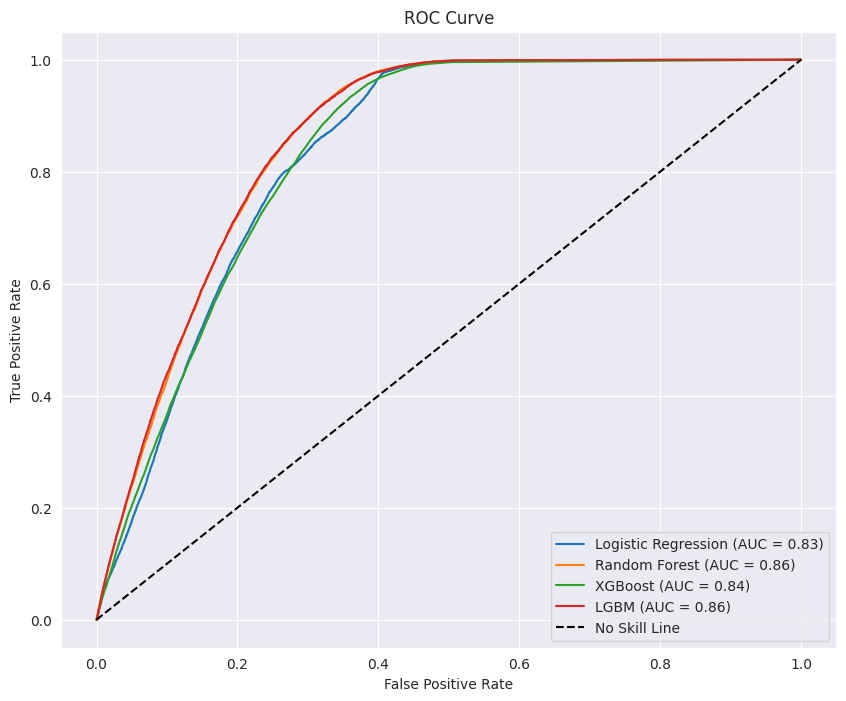

,Model,Precision,Recall,F1-Score,Accuracy,AUC
0,Logistic Regression,0.825948,0.877393,0.820573,0.877393,0.834173
1,Random Forest,0.828302,0.876711,0.826685,0.876711,0.856760
2,XGBoost,0.825132,0.867790,0.836665,0.867790,0.835399
3,LGBM,0.803796,0.876851,0.820552,0.876851,0.857733


In [ ]:
modelling(X_train,y_train,X_test,y_test)

#Feature Engineering

In [ ]:
#Lets bin the numerical columns
df1['age_qcut'] = pd.qcut(df1['Age'], q=4, precision=1,labels=['Youth','Adults','Middle_age','Old'])

In [ ]:

counts = df.groupby(['Policy_Sales_Channel', 'Response']).size().reset_index(name='Count')

# Get the total counts for each 'Policy_Sales_Channel' to calculate percentages
total_counts = counts.groupby('Policy_Sales_Channel')['Count'].transform('sum')

# Calculate the percentage for each group
counts['Percentage'] = (counts['Count'] / total_counts) * 100

# Display the result
print(counts)

     Policy_Sales_Channel  Response  Count  Percentage
0                     1.0         0   1039   96.741155
1                     1.0         1     35    3.258845
2                     2.0         0      3   75.000000
3                     2.0         1      1   25.000000
4                     3.0         0    364   69.598470
..                    ...       ...    ...         ...
269                 159.0         1      1    1.960784
270                 160.0         0  21304   97.819000
271                 160.0         1    475    2.181000
272                 163.0         0   2013   69.581749
273                 163.0         1    880   30.418251

[274 rows x 4 columns]


In [ ]:
channel_counts = df['Policy_Sales_Channel'].value_counts()
channels_to_keep = channel_counts[channel_counts > 1000].index.tolist()

# Filter the dataframe to only include the desired 'Policy_Sales_Channel's
filtered_df = df[df['Policy_Sales_Channel'].isin(channels_to_keep)]

# Group by 'Policy_Sales_Channel' and 'Response' and count the occurrences
grouped_counts = filtered_df.groupby(['Policy_Sales_Channel', 'Response']).size().reset_index(name='Count')

# Calculate the total counts for each 'Policy_Sales_Channel'
channel_totals = grouped_counts.groupby('Policy_Sales_Channel')['Count'].transform('sum')

# Calculate the percentage for each group
grouped_counts['Percentage'] = (grouped_counts['Count'] / channel_totals) * 100

# Sort the results and reset index for better readability
grouped_counts = grouped_counts.sort_values(by=['Policy_Sales_Channel', 'Response']).reset_index(drop=True)

# Display the DataFrame
print(grouped_counts)

    Policy_Sales_Channel  Response   Count  Percentage
0                    1.0         0    1039   96.741155
1                    1.0         1      35    3.258845
2                    7.0         0    1416   88.610763
3                    7.0         1     182   11.389237
4                    8.0         0    1390   91.749175
5                    8.0         1     125    8.250825
6                   11.0         0    1095   91.022444
7                   11.0         1     108    8.977556
8                   13.0         0    1590   85.254692
9                   13.0         1     275   14.745308
10                  25.0         0    1479   80.032468
11                  25.0         1     369   19.967532
12                  26.0         0   63809   80.061481
13                  26.0         1   15891   19.938519
14                  30.0         0    1254   88.936170
15                  30.0         1     156   11.063830
16                  52.0         0     940   89.099526
17        

    Policy_Sales_Channel  Response  Count  Percentage
0                  155.0         1    395   32.009724
1                  163.0         1    880   30.418251
2                  157.0         1   1794   26.840215
3                  154.0         1   1474   24.595361
4                  156.0         1   2297   21.545821
5                   25.0         1    369   19.967532
6                   26.0         1  15891   19.938519
7                  124.0         1  13996   18.914792
8                  122.0         1   1720   17.321249
9                   55.0         1    189   14.952532
10                  13.0         1    275   14.745308
11                 125.0         1    127   12.378168
12                   7.0         1    182   11.389237
13                  30.0         1    156   11.063830
14                  52.0         1    115   10.900474
15                  11.0         1    108    8.977556
16                   8.0         1    125    8.250825
17                   1.0    

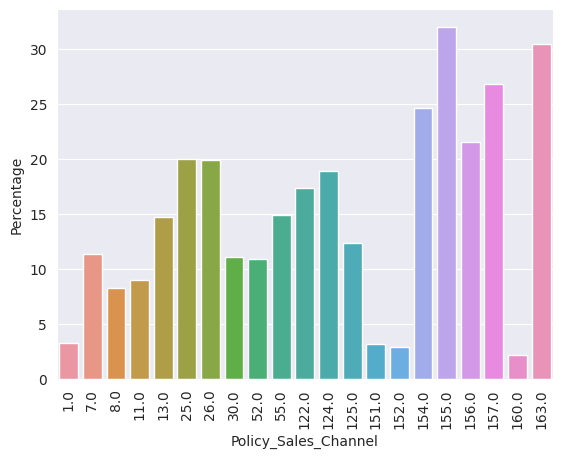

In [ ]:
# Filter the DataFrame for rows where 'Response' is 1
response_1_counts = grouped_counts[grouped_counts['Response'] == 1]

# Sort these rows in decreasing order of 'Percentage'
sorted_response_1 = response_1_counts.sort_values(by='Percentage', ascending=False).reset_index(drop=True)

# Display the sorted DataFrame
print(sorted_response_1)

sns.barplot(x = sorted_response_1['Policy_Sales_Channel'], y=sorted_response_1['Percentage'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
pc_ids = sorted_response_1['Policy_Sales_Channel'].to_list()
df1['pc_ids_yes'] = df1['Policy_Sales_Channel'].apply(lambda x: 1 if x in pc_ids else 0)

df1['pc_ids_ordinal'] = df1['Policy_Sales_Channel'].apply(lambda x: x if x in pc_ids else 999.0)

In [ ]:
df1.columns

Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response', 'age_qcut', 'pc_ids_yes',
       'pc_ids_ordinal'],
      dtype='object')

In [ ]:
df['Annual_Premium'].describe()

count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max      540165.000000
Name: Annual_Premium, dtype: float64

Previously_Insured
0    2630.0
1    2630.0
Name: Annual_Premium, dtype: float64

In [ ]:


#Age_premium
#insu_premioum
#Policy_premium
#region_code_pre

def get_mean_premium(df,col):
    mean_prem_per_col = df.groupby(col)['Annual_Premium'].mean()
    return df[col].map(mean_prem_per_col)



df1['age_qcut_prem_mean'] = get_mean_premium(df1,'age_qcut')
df1['prev_ins_prem_mean'] = get_mean_premium(df1,'Previously_Insured')
df1['pol_chan_prem_mean'] = get_mean_premium(df1,'Policy_Sales_Channel')
df1['rgn_code_prem_mean'] = get_mean_premium(df1,'Region_Code')


In [ ]:
df1.drop(['age_qcut_prem_mode','prev_ins_prem_mode','pol_chan_prem_mode','rgn_code_prem_mode'],axis=1,inplace=True)

# def get_mode_premium(df, col):
#     # Function to calculate the mode
#     def calculate_mode(group):
#         return group.mode().iloc[0]

#     # Calculate mode for each category in the specified column
#     mode_prem_per_col = df.groupby(col)['Annual_Premium'].apply(calculate_mode)

#     # Map the mode values back to the original DataFrame
#     return df[col].map(mode_prem_per_col)

# df1['age_qcut_prem_mode'] = get_mode_premium(df1, 'age_qcut')
# df1['prev_ins_prem_mode'] = get_mode_premium(df1, 'Previously_Insured')
# df1['pol_chan_prem_mode'] = get_mode_premium(df1, 'Policy_Sales_Channel')
# df1['rgn_code_prem_mode'] = get_mode_premium(df1, 'Region_Code')

In [ ]:
df1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_qcut,pc_ids_yes,pc_ids_ordinal,age_qcut_prem_mean,prev_ins_prem_mean,pol_chan_prem_mean,rgn_code_prem_mean
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,Middle_age,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0,Old,1,26.0,32649.264833,30496.815760,33654.241355,24524.480813
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1,Middle_age,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0,Youth,1,152.0,30619.278949,30644.289198,30889.192493,27607.283146
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0,Adults,1,152.0,28142.723586,30644.289198,30889.192493,30949.127471


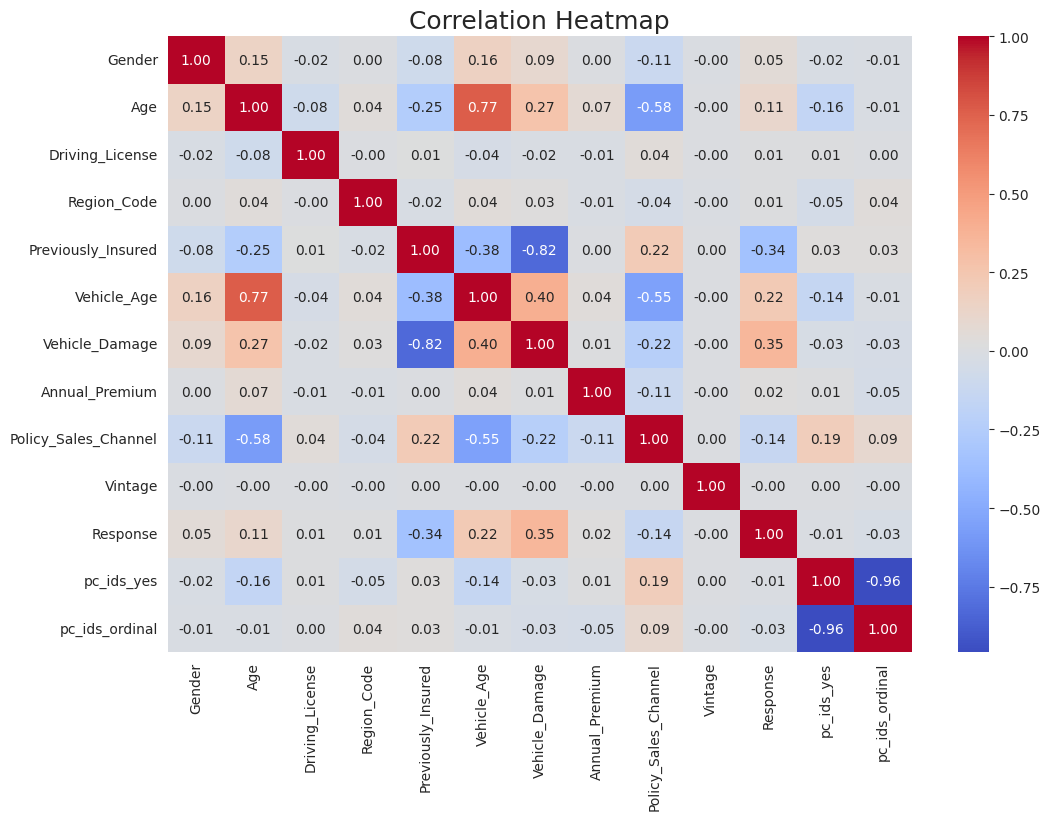

In [ ]:
corr_matrix = df1.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

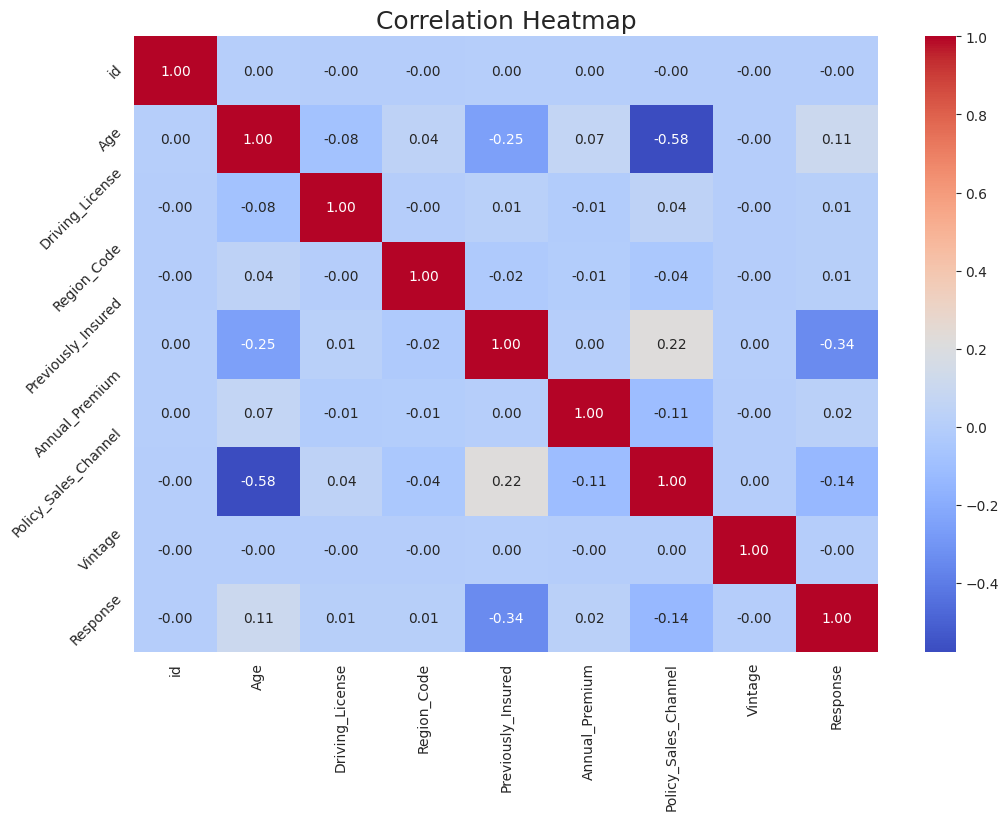

In [ ]:
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# df1['Gender'] = df1['Gender'].map({'Male': 1, 'Female': 0})
# df1['Vehicle_Age'] = df1['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
# df1['Vehicle_Damage'] = df1['Vehicle_Damage'].map({'Yes': 1, 'No': 0})

df1['age_qcut'] = df1['age_qcut'].map({'Youth': 0,'Adults': 1,'Middle_age': 2,'Old': 3})
df1.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_qcut,pc_ids_yes,pc_ids_ordinal,age_qcut_prem_mean,prev_ins_prem_mean,pol_chan_prem_mean,rgn_code_prem_mean
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,2,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0,3,1,26.0,32649.264833,30496.815760,33654.241355,24524.480813
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1,2,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0,0,1,152.0,30619.278949,30644.289198,30889.192493,27607.283146
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0,1,1,152.0,28142.723586,30644.289198,30889.192493,30949.127471


In [ ]:
df1['age_qcut'] = df1['age_qcut'].astype('int')
df1['age_qcut_prem_mean'] = df1['age_qcut_prem_mean'].astype('float')

X_train, X_test, y_train, y_test = train_test_split(df1.drop('Response',axis=1), df1['Response'], test_size=0.3, random_state=42,stratify=df1['Response'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(266776, 17) (114333, 17) (266776,) (114333,)


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc


def modelling_1(X_train, y_train,X_test,y_test,var ='XGB'):
  if var == 'rf':
    model = RandomForestClassifier()
  elif var == 'XGB':
    print('XGB called')
    model = XGBClassifier()
  else:
    print('LGB called')
    model = LGBMClassifier()

  model.fit(X_train, y_train)

  preds = model.predict(X_test)
  print(confusion_matrix(y_test, preds))
  print(classification_report(y_test, preds))
  print('Recall Score\n')
  print(recall_score(y_test,preds))
  print('Preicison Score')
  print(precision_score(y_test,preds))


  feature_importances = model.feature_importances_

  # Convert the importances into a pandas Series for easy manipulation
  importances = pd.Series(feature_importances, index=X_train.columns)

  # Sort the feature importances in descending order
  sorted_importances = importances.sort_values(ascending=False)

  # Visualize the feature importances
  plt.figure(figsize=(10, 6))
  sorted_importances.plot(kind='bar')
  plt.title('Feature Importances')
  plt.xlabel('Features')
  plt.ylabel('Importance')
  plt.show()



  fpr, tpr, thresholds = roc_curve(y_test, preds)

  fig = px.area(
      x=fpr, y=tpr,
      title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
      labels=dict(x='False Positive Rate', y='True Positive Rate'),
      width=700, height=500
  )
  fig.add_shape(
      type='line', line=dict(dash='dash'),
      x0=0, x1=1, y0=0, y1=1
  )

  fig.update_yaxes(scaleanchor="x", scaleratio=1)
  fig.update_xaxes(constrain='domain')
  fig.show()
  return model

XGB called
[[99775   545]
 [13569   444]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    100320
           1       0.45      0.03      0.06     14013

    accuracy                           0.88    114333
   macro avg       0.66      0.51      0.50    114333
weighted avg       0.83      0.88      0.83    114333

Recall Score

0.03168486405480625
Preicison Score
0.448938321536906


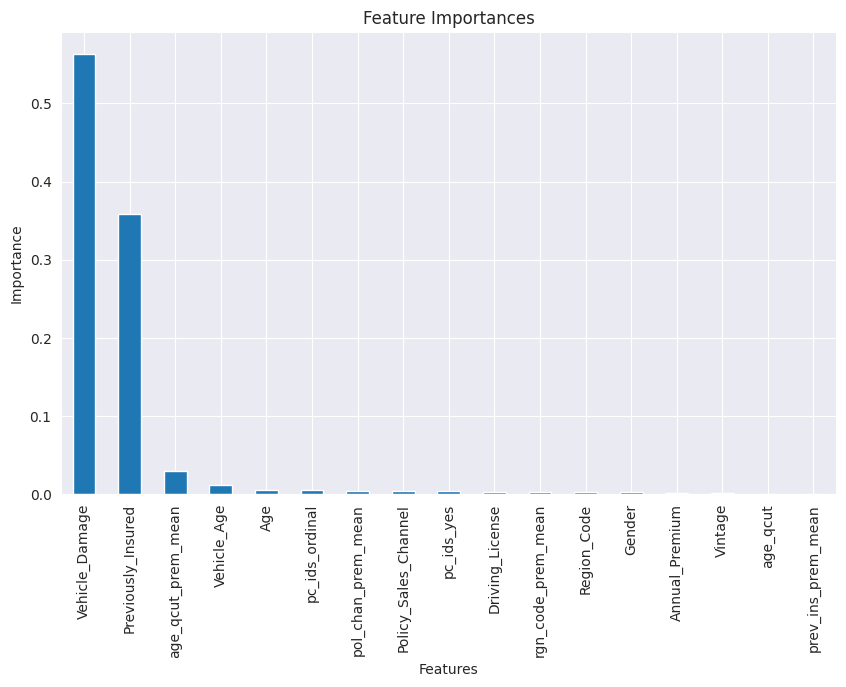

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
modelling_1(X_train, y_train,X_test,y_test,var ='XGB')

LGB called
[LightGBM] [Info] Number of positive: 32697, number of negative: 234079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 266776, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968375
[LightGBM] [Info] Start training from score -1.968375
[[100192    128]
 [ 13967     46]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100320
           1       0.26      0.00      0.01     14013

    accuracy                           0.88    114333
   macro avg       0.57      0.50      0.47    114333
weighted avg       0.80      0.88      0.82    114333

Recall Score

0.003282666095768215
Preicison Score
0.264367816091954

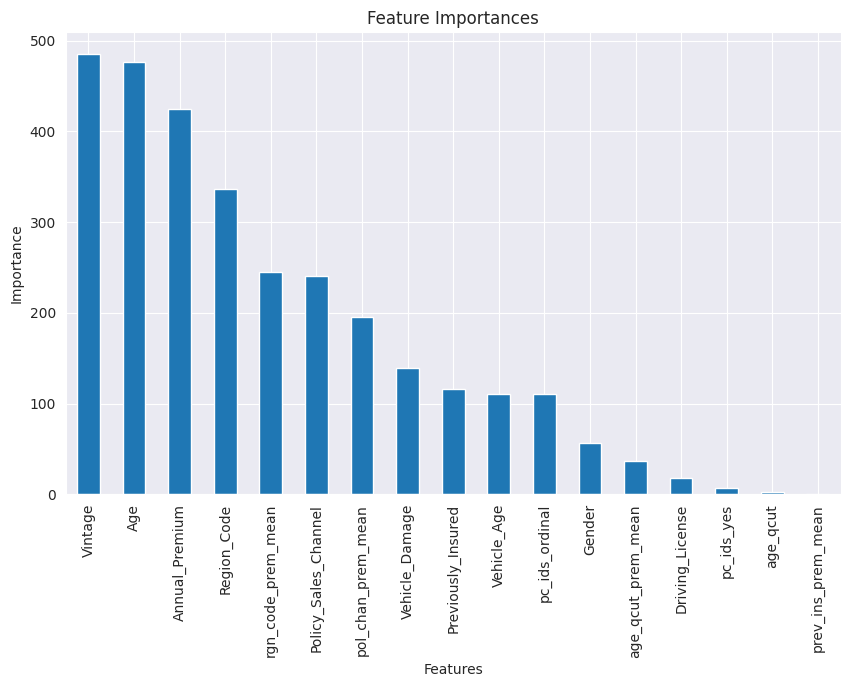

LGBMClassifier()

In [ ]:
modelling_1(X_train, y_train,X_test,y_test,var ='')

[[96899  3421]
 [12080  1933]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    100320
           1       0.36      0.14      0.20     14013

    accuracy                           0.86    114333
   macro avg       0.63      0.55      0.56    114333
weighted avg       0.82      0.86      0.84    114333

Recall Score

0.1379433383286948
Preicison Score
0.3610384759058648


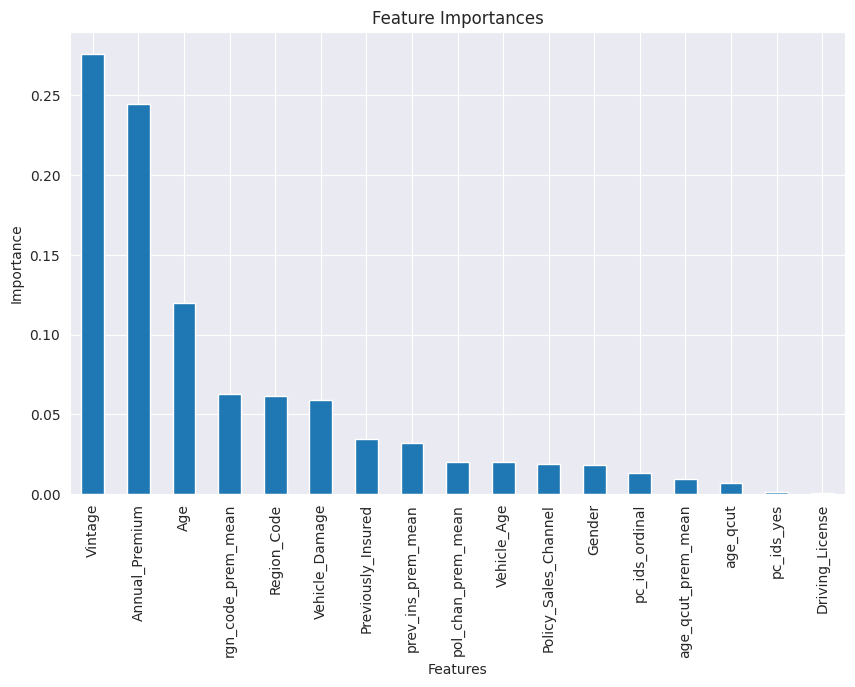

RandomForestClassifier()

In [ ]:
modelling_1(X_train, y_train,X_test,y_test,var ='rf')

#Feature Engineering 2

In [ ]:
#Since VIntage , Annual _premium, Age, Rgion_code and Policy_channel_code can be used
#Vintage is how manu days the customer is with the compay , we can get this in weeks,
#ALso lloking closley , we can see that the numrical columns are contributing more to the model


In [ ]:
df1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_qcut,pc_ids_yes,pc_ids_ordinal,age_qcut_prem_mean,prev_ins_prem_mean,pol_chan_prem_mean,rgn_code_prem_mean
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1,2,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0,3,1,26.0,32649.264833,30496.815760,33654.241355,24524.480813
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1,2,1,26.0,30388.858871,30496.815760,33654.241355,38668.865245
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0,0,1,152.0,30619.278949,30644.289198,30889.192493,27607.283146
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0,1,1,152.0,28142.723586,30644.289198,30889.192493,30949.127471


In [ ]:
df1['Vintage_week'] = df1['Vintage'].apply(lambda x: x//7)


In [ ]:
df1['mean_age_region']=df1.groupby(['Region_Code'])['Age'].transform('mean')
df1['mean_age_policy'] = df1.groupby(['Policy_Sales_Channel'])['Age'].transform('mean')


In [ ]:
df1['cnt_policy_per_region'] = df1.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('count')

df1['n_policy_per_region'] = df1.groupby(['Region_Code'])['Policy_Sales_Channel'].transform('nunique')

In [ ]:
df1['premium_age_ratio'] = df1['Annual_Premium']/df1['Age']
df1['premium_vintage_ratio'] = df1['Annual_Premium']/df1['Vintage']


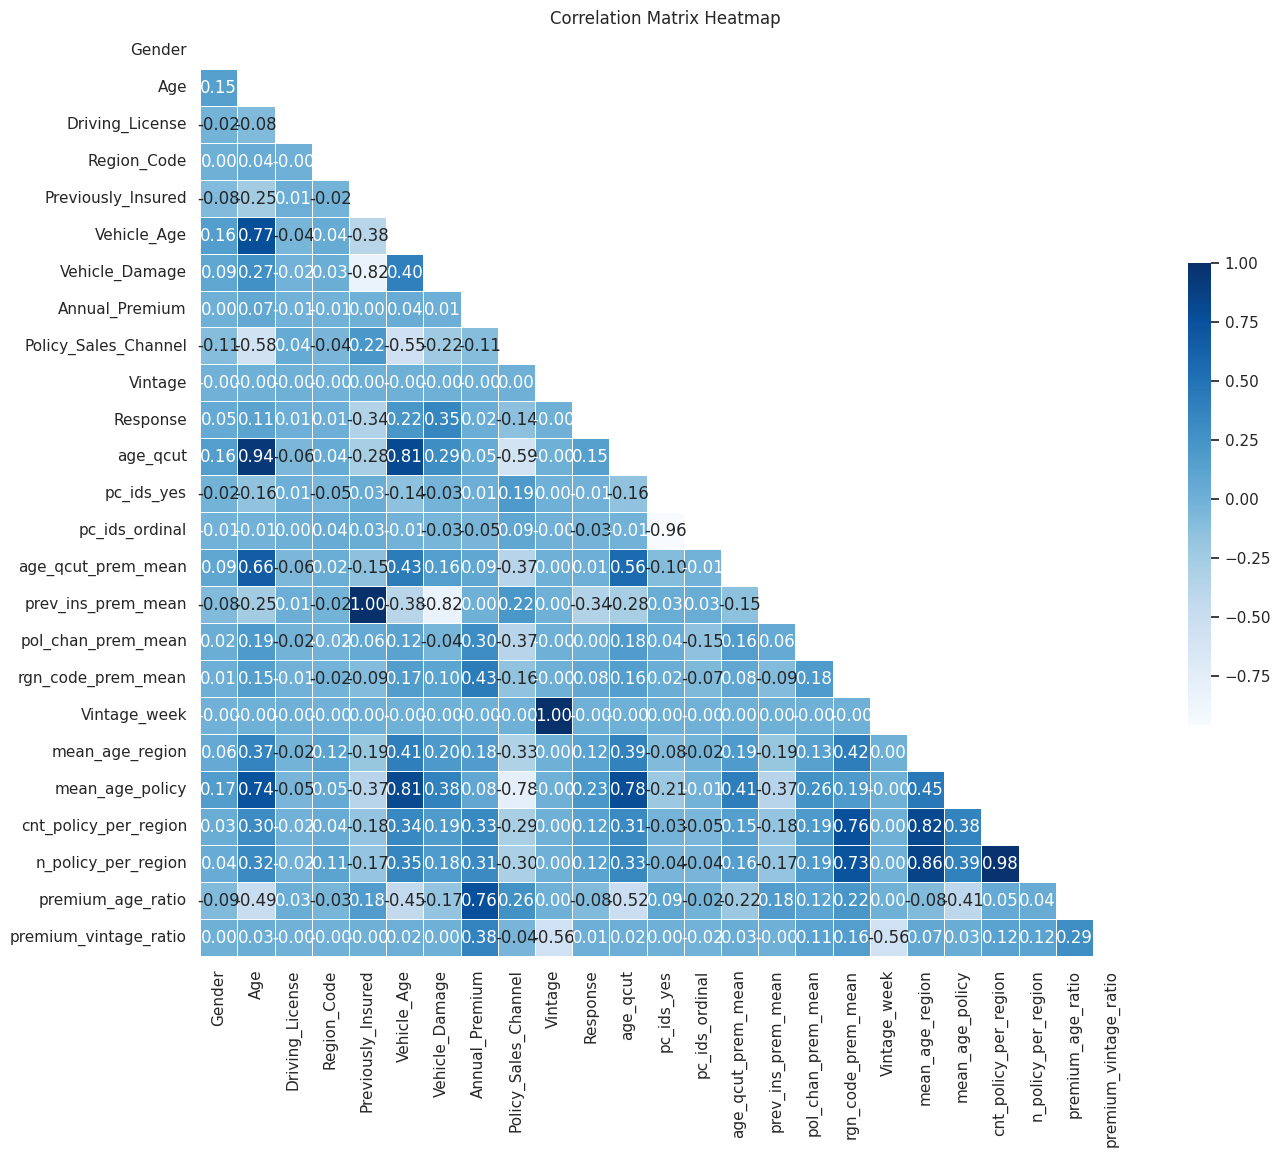

In [ ]:
corr_matrix = df1.corr()

# Set up the matplotlib figure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Set the seaborn theme
sns.set_theme(style="white")

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='Blues',
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
corr_matrix['Response'].sort_values()

Previously_Insured      -0.341170
prev_ins_prem_mean      -0.341170
Policy_Sales_Channel    -0.139042
premium_age_ratio       -0.080740
pc_ids_ordinal          -0.032620
pc_ids_yes              -0.008096
Vintage_week            -0.001080
Vintage                 -0.001050
pol_chan_prem_mean       0.000296
age_qcut_prem_mean       0.007849
premium_vintage_ratio    0.009212
Driving_License          0.010155
Region_Code              0.010570
Annual_Premium           0.022575
Gender                   0.052440
rgn_code_prem_mean       0.080712
Age                      0.111147
mean_age_region          0.118997
cnt_policy_per_region    0.120662
n_policy_per_region      0.121856
age_qcut                 0.149336
Vehicle_Age              0.221874
mean_age_policy          0.225351
Vehicle_Damage           0.354400
Response                 1.000000
Name: Response, dtype: float64

(266776, 24) (114333, 24) (266776,) (114333,)
XGB called
[[99816   504]
 [13557   456]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    100320
           1       0.47      0.03      0.06     14013

    accuracy                           0.88    114333
   macro avg       0.68      0.51      0.50    114333
weighted avg       0.83      0.88      0.83    114333

Recall Score

0.03254121173196318
Preicison Score
0.475


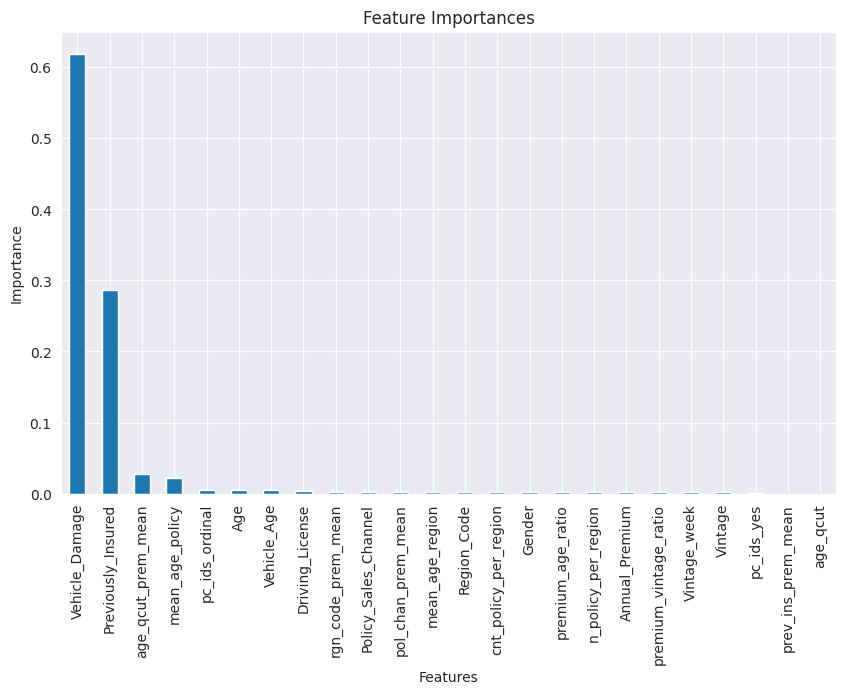

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop('Response',axis=1), df1['Response'], test_size=0.3, random_state=42,stratify=df1['Response'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = modelling(X_train,y_train,X_test,y_test,'XGB')


[[97417  2903]
 [12291  1722]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93    100320
           1       0.37      0.12      0.18     14013

    accuracy                           0.87    114333
   macro avg       0.63      0.55      0.56    114333
weighted avg       0.82      0.87      0.84    114333

Recall Score

0.12288589167201884
Preicison Score
0.37232432432432433


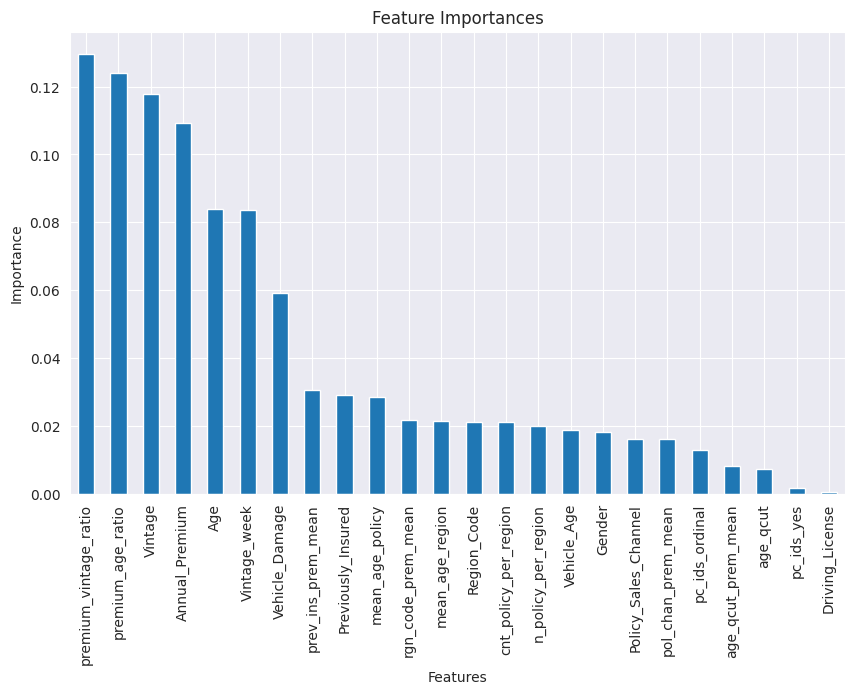

In [ ]:
model = modelling(X_train,y_train,X_test,y_test,'rf')

LGB called
[LightGBM] [Info] Number of positive: 32697, number of negative: 234079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1811
[LightGBM] [Info] Number of data points in the train set: 266776, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122563 -> initscore=-1.968375
[LightGBM] [Info] Start training from score -1.968375
[[100233     87]
 [ 13972     41]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    100320
           1       0.32      0.00      0.01     14013

    accuracy                           0.88    114333
   macro avg       0.60      0.50      0.47    114333
weighted avg       0.81      0.88      0.82    114333

Recall Score

0.002925854563619496
Preicison Score
0.3203125


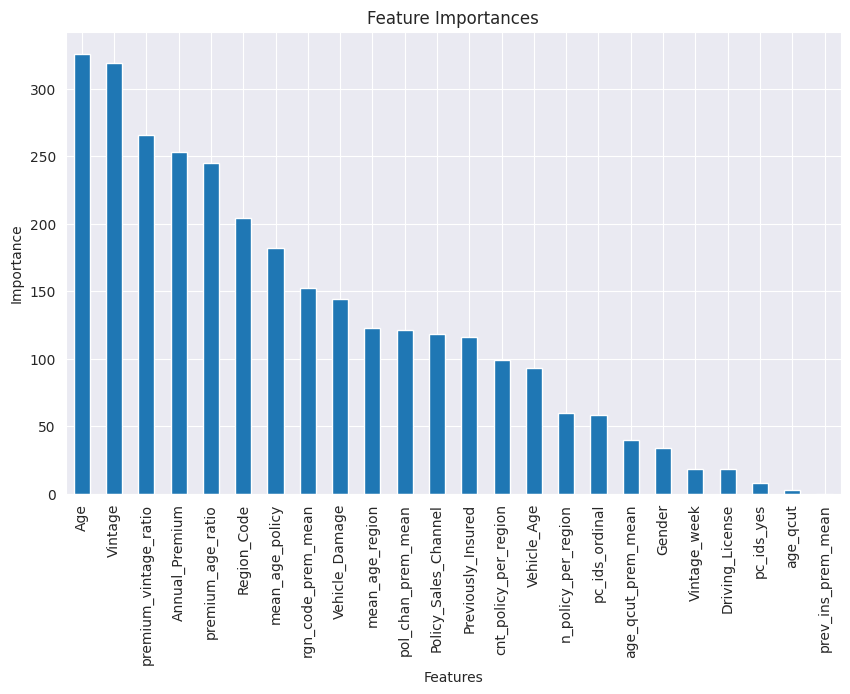

In [ ]:
model = modelling(X_train,y_train,X_test,y_test,'')

#SMOTE or Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

# Assuming you have a DataFrame 'df' with features and a target column 'target'

# Separate your features and target variable
X = df1.drop('Response', axis=1)
y = df1['Response']

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Before applying SMOTE, checking the class distribution
print("Before SMOTE:", Counter(y_train))

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Fit the SMOTE object to the training data to balance it
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the class distribution after applying SMOTE
print("After SMOTE:", Counter(y_train_smote))

Before SMOTE: Counter({0: 267700, 1: 37187})
After SMOTE: Counter({1: 267700, 0: 267700})


LGB called
[LightGBM] [Info] Number of positive: 267700, number of negative: 267700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.113673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3680
[LightGBM] [Info] Number of data points in the train set: 535400, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[[52012 14687]
 [ 2689  6834]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     66699
           1       0.32      0.72      0.44      9523

    accuracy                           0.77     76222
   macro avg       0.63      0.75      0.65     76222
weighted avg       0.87      0.77      0.80     76222

Recall Score

0.717630998634884
Preicison Score
0.3175502997072627


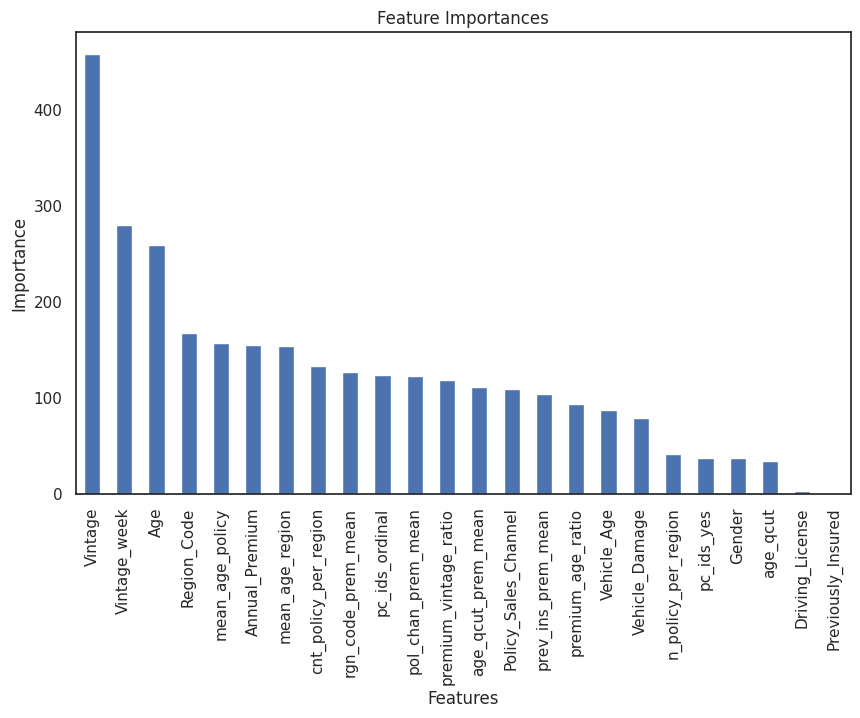

LGBMClassifier()

In [ ]:
modelling_1(X_train_smote,y_train_smote,X_test,y_test,'')

[[56397 10302]
 [ 4660  4863]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     66699
           1       0.32      0.51      0.39      9523

    accuracy                           0.80     76222
   macro avg       0.62      0.68      0.64     76222
weighted avg       0.85      0.80      0.82     76222

Recall Score

0.510658405964507
Preicison Score
0.32067260138476755


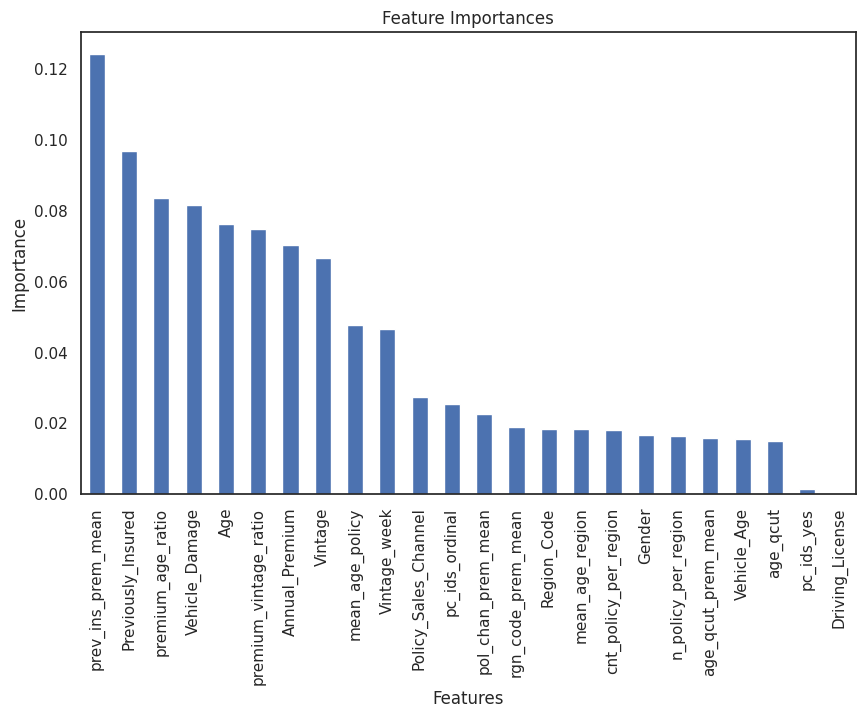

RandomForestClassifier()

In [ ]:
modelling_1(X_train_smote,y_train_smote,X_test,y_test,'rf')

XGB called
[[54391 12308]
 [ 3548  5975]]
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     66699
           1       0.33      0.63      0.43      9523

    accuracy                           0.79     76222
   macro avg       0.63      0.72      0.65     76222
weighted avg       0.86      0.79      0.82     76222

Recall Score

0.6274283314081697
Preicison Score
0.32680632281354266


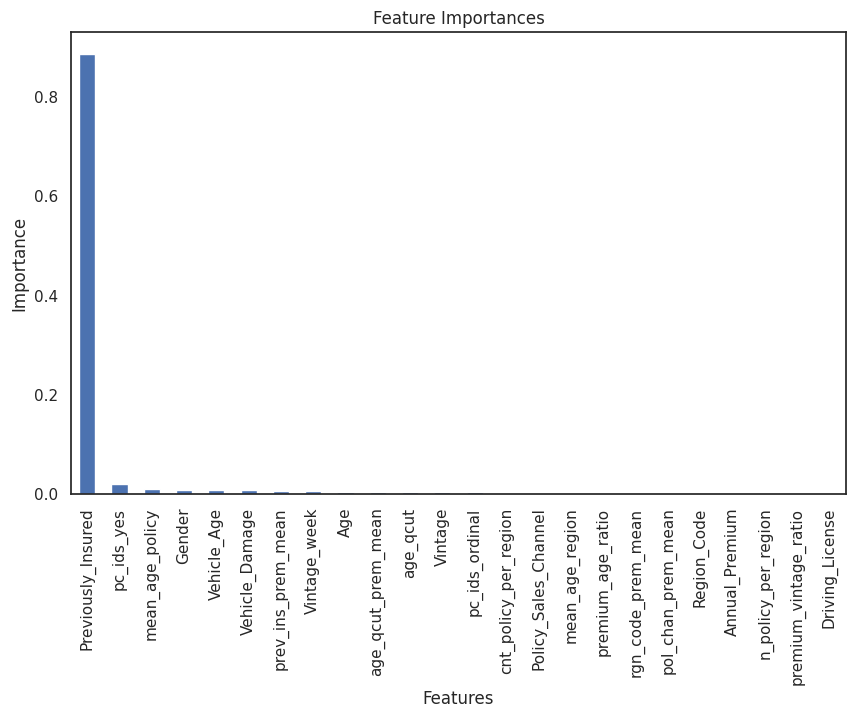

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
modelling(X_train_smote,y_train_smote,X_test,y_test,'XGB')

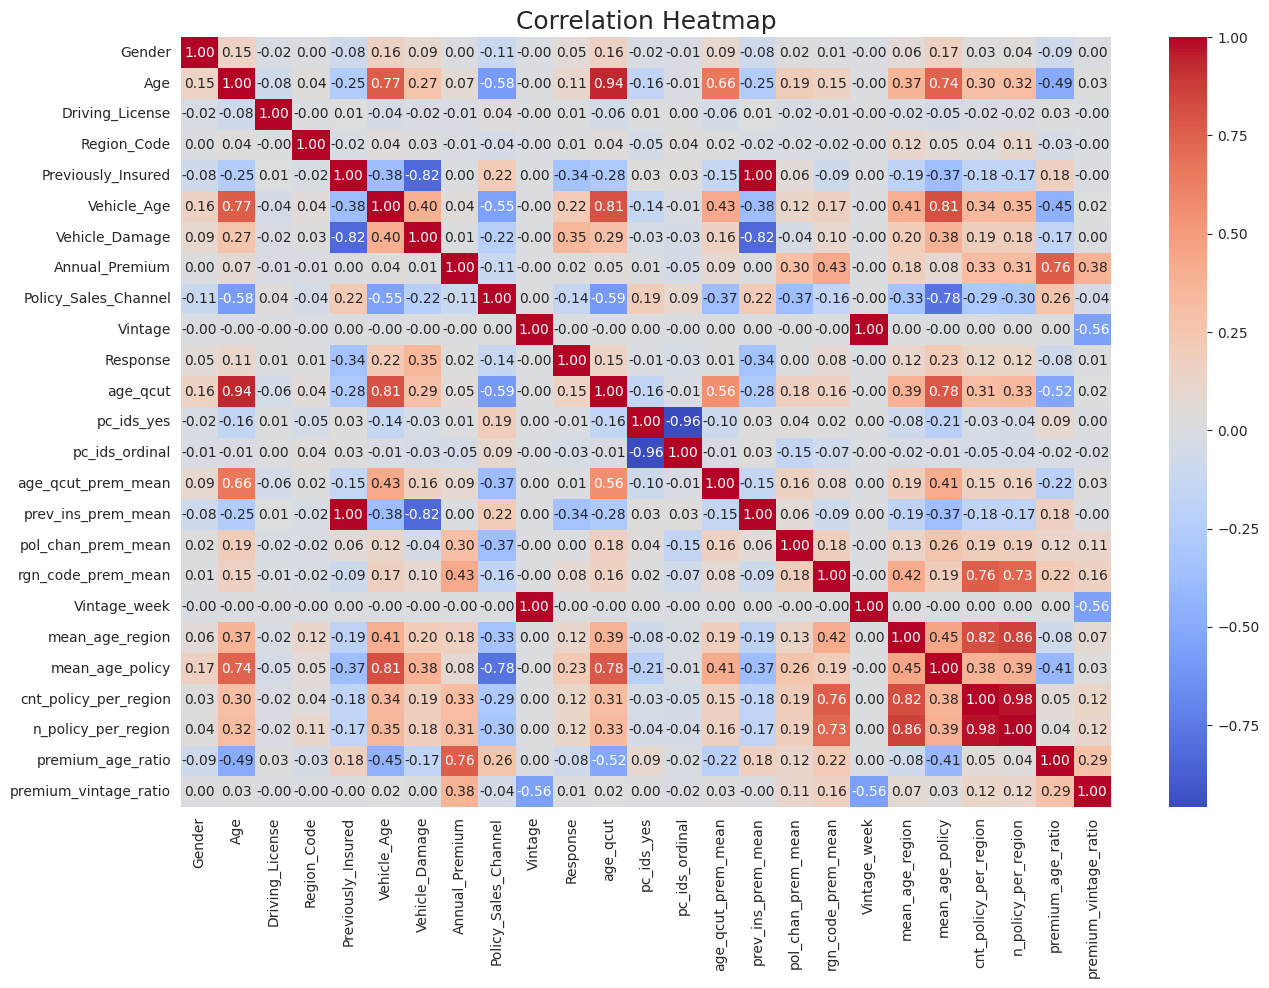

In [ ]:
#feature selection :
corr_matrix = df1.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Generate a heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=18)
plt.xticks(rotation=90)


# Show the plot
plt.show()


In [ ]:
df1.corr()['Response'].sort_values(ascending=False)[(df1.corr()['Response'].sort_values(ascending=False).values>0.1) and (df1.corr()['Response'].sort_values(ascending=False).values<-0.1)]

ValueError: ignored

In [ ]:
# Calculate the correlation with 'Response' and sort the values
corr_with_response = df1.corr()['Response'].sort_values(ascending=False)

# Apply the conditions for correlation values
filtered_columns = corr_with_response[(corr_with_response > 0.1) | (corr_with_response < -0.1)].index
filtered_columns

Index(['Response', 'Vehicle_Damage', 'mean_age_policy', 'Vehicle_Age',
       'age_qcut', 'n_policy_per_region', 'cnt_policy_per_region',
       'mean_age_region', 'Age', 'Policy_Sales_Channel', 'prev_ins_prem_mean',
       'Previously_Insured'],
      dtype='object')

#Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
      'learning_rate': [0.1, 0.01],
      'n_estimators': [50, 100, 150],
      'max_depth': [4, 6],
      'subsample': [0.7, 0.8, 0.9],
      'min_child_samples': [1, 5, 10]
  }

# Initialize the LGBM Classifier
lgbm = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Get best parameters and best score
print(grid_search.best_params_)
print(grid_search.best_score_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Total Bins 3657
[LightGBM] [Info] Number of data points in the train set: 356933, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000006
[LightGBM] [Info] Start training from score 0.000006
[LightGBM] [Info] Number of positive: 178467, number of negative: 178467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3670
[LightGBM] [Info] Number of data points in the train set: 356934, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 178466, number of negative: 178467
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031717 seconds.
You ca

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.1, 'max_depth': 6, 'min_child_samples': 5, 'n_estimators': 150, 'subsample': 0.7}
0.9285070356413261


In [ ]:
lgbm = LGBMClassifier(**grid_search.best_params_)
lgbm.fit(X_train_smote, y_train_smote)
pred = lgbm.predict(X_test)
print(classification_report(y_test, pred))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 267700, number of negative: 267700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3680
[LightGBM] [Info] Number of data points in the train set: 535400, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     6

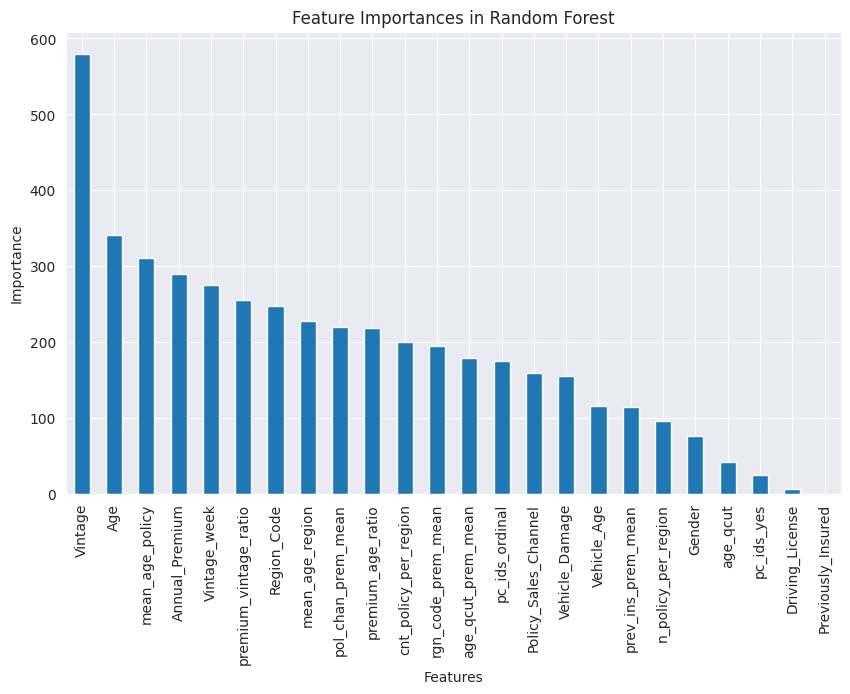

In [ ]:
# Extract feature importances
feature_importances = lgbm.feature_importances_

# Convert the importances into a pandas Series for easy manipulation
importances = pd.Series(feature_importances, index=X_train_smote.columns)

# Sort the feature importances in descending order
sorted_importances = importances.sort_values(ascending=False)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances in Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()


In [ ]:
import pickle

# Assuming 'model' is the trained machine learning model
with open('lgbm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# X_train_smote.to_csv('X_train_smote.csv',index=False)
# y_train_smote.to_csv('y_train_smote.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_test.to_csv('y_test.csv',index=False)


In [ ]:
train_data, validation_data, test_data = np.split(df1.sample(frac=1, random_state=42), [int(0.7 * len(df)), int(0.9 * len(df))])

In [ ]:
train_data['']

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_qcut,pc_ids_yes,pc_ids_ordinal,age_qcut_prem_mean,prev_ins_prem_mean,pol_chan_prem_mean,rgn_code_prem_mean,Vintage_week,mean_age_region,mean_age_policy,cnt_policy_per_region,n_policy_per_region,premium_age_ratio,premium_vintage_ratio
200222,0,21,1,3.0,1,0,0,20408.0,160.0,72,0,0,1,160.0,30619.278949,30644.289198,25575.744938,24524.480813,10,36.838936,23.435006,9251,56,971.809524,283.444444
49766,1,55,1,15.0,0,1,1,37498.0,26.0,102,0,3,1,26.0,32649.264833,30496.815760,33654.241355,29624.520815,14,32.605876,50.683413,13308,45,681.781818,367.627451
172201,0,41,1,3.0,0,1,1,2630.0,26.0,90,0,2,1,26.0,30388.858871,30496.815760,33654.241355,24524.480813,12,36.838936,50.683413,9251,56,64.146341,29.222222
160713,0,26,1,11.0,0,0,0,2630.0,151.0,268,0,1,1,151.0,28142.723586,30496.815760,29307.498069,27607.283146,38,34.374567,25.566281,9232,45,101.153846,9.813433
53272,1,51,1,40.0,0,1,1,34006.0,124.0,265,0,3,1,124.0,32649.264833,30496.815760,31710.191162,26387.699614,37,35.908880,46.923589,1295,34,666.784314,128.324528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61067,1,31,1,28.0,0,1,1,35129.0,124.0,195,0,1,1,124.0,28142.723586,30496.815760,31710.191162,38668.865245,27,46.256853,46.923589,106415,122,1133.193548,180.148718
211630,1,23,1,12.0,1,0,0,27855.0,152.0,104,0,0,1,152.0,30619.278949,30644.289198,30889.192493,23445.990619,14,33.870857,26.214825,3198,34,1211.086957,267.836538
119891,0,20,1,37.0,1,0,0,47306.0,160.0,147,0,0,1,160.0,30619.278949,30644.289198,25575.744938,28501.944919,21,32.496273,23.435006,5501,51,2365.300000,321.809524
33534,0,52,1,28.0,0,1,0,60428.0,26.0,49,0,3,1,26.0,32649.264833,30496.815760,33654.241355,38668.865245,7,46.256853,50.683413,106415,122,1162.076923,1233.224490
